## 项目背景
此项目是2017年biendata上的一个比赛项目，赛事方提供了300万行的训练数据和200万行的测试数据，旨在预测用户骑行目的地的区块位置。  
本文将使用项目中给出的训练集数据train.csv进行数据的探索性分析，利用python工具来探索用户骑行规律，暂不涉及建模。

## 数据概况

![部分数据已进行脱敏处理](https://img-blog.csdnimg.cn/20190626224047160.jpg?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3p3Ymx1ZXNreTE5OTE=,size_16,color_FFFFFF,t_70)

In [2]:
#导入所需要的包
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians,cos,sin,asin,sqrt
%matplotlib inline

In [3]:
train = pd.read_csv('C:/Users/Administrator/Desktop/soton保障班/MOBIKE_CUP_2017/train.csv', sep = ',', parse_dates = ['starttime'])
test = pd.read_csv('C:/Users/Administrator/Desktop/soton保障班/MOBIKE_CUP_2017/test.csv', sep = ',', parse_dates = ['starttime'])

In [4]:
train.head()

,orderid,userid,bikeid,biketype,starttime,geohashed_start_loc,geohashed_end_loc
0,1893973,451147,210617,2,2017-05-14 22:16:50,wx4snhx,wx4snhj
1,4657992,1061133,465394,1,2017-05-14 22:16:52,wx4dr59,wx4dquz
2,2965085,549189,310572,1,2017-05-14 22:16:51,wx4fgur,wx4fu5n
3,4548579,489720,456688,1,2017-05-14 22:16:51,wx4d5r5,wx4d5r4
4,3936364,467449,403224,1,2017-05-14 22:16:50,wx4g27p,wx4g266


In [5]:
test.head()

,orderid,userid,bikeid,biketype,starttime,geohashed_start_loc
0,86458,467987,13488,1,2017-05-27 19:19:41,wx4gfbe
1,1473189,976462,170537,2,2017-05-31 17:45:38,wx4eqep
2,1441027,790813,167447,2,2017-05-26 11:31:48,wx4e5zr
3,4747983,744823,472963,1,2017-05-31 18:30:43,wx4dxz4
4,43984,712391,7158,1,2017-05-25 12:46:16,wx4ewq5


[Geohash精度和原理](https://blog.csdn.net/u011497262/article/details/81210634)，感兴趣的可以查看一下，这里不探究，只应用。

In [6]:
import geohash

In [7]:
train.shape

(3214096, 7)

In [8]:
test.shape

(2002996, 6)

训练集有320万条数据，测试集有200万条数据，训练集比测试集多了一列geohashed_end_loc，即是测试集需要预测的目的地。

In [9]:
train['userid'].unique().size

349693

In [10]:
train['bikeid'].unique().size

485465

In [11]:
train['biketype'].unique().size

2

训练数据涉及近35万用户，48万辆车，2种车型。

## 数据处理

由于原测试集数据量较大，自己电脑运行较慢，所以随记挑选50%进行分析。

In [12]:
train = train.sample(frac=0.5)

### 基本思路：  
1.将起始日期分成星期，天，小时，方便后续进行不同时间的分析；  
2.将geohash编码进行反编码，进行骑行距离的计算，并用neighbors方法算出以起点为中心的九宫格编码；  
3.考虑到geohash7位编码距离较小，仅为153m × 153m的范围，实际骑行中基本都能超出范围，所以将7位编码转化成6位编码，范围增加到 1.22km × 0.61km，较为符合实际情况；  
4.利用geohash判断训练集中的目的地是否在九宫格内；  
5.计算骑行距离，公式直接从网上找的

In [13]:
def _processData(df):
    #将starttime 分成weekday,day,hour三类，方便后续不同时间段数据展示
    df['weekday'] = df['starttime'].apply(lambda s : s.weekday())
    df['day'] = df['starttime'].apply(lambda s : str(s)[:10])
    df['hour'] = df['starttime'].apply(lambda s : s.hour)
    print('时间处理完成！！！')
    
    #将geohash字符串反编码，方便后续计算骑行距离
    df['start_lat_lng'] = df['geohashed_start_loc'].apply(lambda s : geohash.decode(s))
    df['end_lat_lng'] = df['geohashed_end_loc'].apply(lambda s : geohash.decode(s))
    df['start_neighbors'] = df["geohashed_start_loc"].apply(lambda s : geohash.neighbors(s))
    
    #原数据中的geohash字符串是g7，现在转成g6
    df['geohashed_start_loc_6'] = df['geohashed_start_loc'].apply(lambda s : s[:6])
    df['geohashed_end_loc_6'] = df['geohashed_end_loc'].apply(lambda s : s[:6])
    df['start_neighbors_6'] = df["geohashed_start_loc_6"].apply(lambda s : geohash.neighbors(s))
    print('Geohash处理完成！！！')
    
    #判断目的地是否在neighbors
    def inGeohash(start_geohash, end_geohash, names):
        names.append(start_geohash)
        if end_geohash in names:
            return 1
        else:
            return 0
    df['inside'] = df.apply(lambda s : inGeohash(s['geohashed_start_loc'],s['geohashed_end_loc'],s['start_neighbors']), axis = 1)
    df['inside_6'] = df.apply(lambda s : inGeohash(s['geohashed_start_loc_6'],s['geohashed_end_loc_6'],s['start_neighbors_6']), axis = 1)
    print("Geohash近邻判断处理完成！！！")
    
    #计算起点与终点距离
    def haversine(lon1, lat1, lon2, lat2): 
        """
        Calculate the great circle distance between two points 
        on the earth (specified in decimal degrees)
        """
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
        # haversine公式
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        r = 6371 # 地球平均半径，单位为公里
        return c * r * 1000
    df['start_end_distance'] = df.apply(lambda s : haversine(s['start_lat_lng'][0],s['start_lat_lng'][1],s['end_lat_lng'][0],
                                                             s['end_lat_lng'][1]),axis = 1)
    print("距离计算完成！！！")
    return df

In [15]:
train = _processData(train)

时间处理完成！！！
Geohash处理完成！！！
Geohash近邻判断处理完成！！！
距离计算完成！！！


In [16]:
train.head()

,orderid,userid,bikeid,biketype,starttime,geohashed_start_loc,geohashed_end_loc,weekday,day,hour,start_lat_lng,end_lat_lng,start_neighbors,geohashed_start_loc_6,geohashed_end_loc_6,start_neighbors_6,inside,inside_6,start_end_distance
1705822,3865329,48392,396399,1,2017-05-16 16:08:31,wx4fk2d,wx4fk31,1,2017-05-16,16,"(39.77394104003906, 116.55738830566406)","(39.77668762207031, 116.55601501464844)","[wx4fk29, wx4fk2e, wx4fk2c, wx4fk2f, wx4fk2g, ...",wx4fk2,wx4fk3,"[wx4fk0, wx4fk8, wx4fk1, wx4fk3, wx4fk9, wx4fh...",0,1,204.846028
1472084,422094,832259,58039,1,2017-05-15 12:31:24,wx4g61e,wx4g3bm,0,2017-05-15,12,"(39.95521545410156, 116.45988464355469)","(39.94834899902344, 116.45164489746094)","[wx4g61d, wx4g61s, wx4g61f, wx4g61g, wx4g61u, ...",wx4g61,wx4g3b,"[wx4g3c, wx4g63, wx4g3f, wx4g64, wx4g66, wx4g3...",0,1,977.321903
1019008,4921869,896352,486992,1,2017-05-14 13:42:07,wx4etvp,wx4etuf,6,2017-05-14,13,"(40.01838684082031, 116.27861022949219)","(40.01701354980469, 116.27174377441406)","[wx4etvn, wx4ewj0, wx4etvq, wx4etvr, wx4ewj2, ...",wx4etv,wx4etu,"[wx4ett, wx4ewj, wx4etw, wx4ety, wx4ewn, wx4et...",0,1,766.501618
1184782,172210,332583,24093,1,2017-05-14 08:52:12,wx5h2en,wx5h2ee,6,2017-05-14,8,"(40.13923645019531, 116.74964904785156)","(40.14198303222656, 116.74552917480469)","[wx5h2ej, wx5h2ep, wx5h2em, wx5h2eq, wx5h2er, ...",wx5h2e,wx5h2e,"[wx5h27, wx5h2g, wx5h2k, wx5h2s, wx5h2u, wx5h2...",0,1,478.285160
1582564,2703085,30524,286455,2,2017-05-15 20:07:45,wx4g55u,wx4g54q,0,2017-05-15,20,"(39.92362976074219, 116.50520324707031)","(39.91539001464844, 116.50794982910156)","[wx4g55g, wx4g55v, wx4g5h5, wx4g5hh, wx4g5hj, ...",wx4g55,wx4g54,"[wx4g4g, wx4g57, wx4g4u, wx4g5h, wx4g5k, wx4g4...",0,1,510.371464


## 数据分析

### 1、从日期上进行分析

In [17]:
def _timeAnalysis(df):
    #数据包含的天数
    print('数据集包含的天数如下：')
    print(df['day'].unique())
    print('*'*60)
    
    #用户出行小时高峰期
    g1 = df.groupby('hour')
    print(g1['orderid'].count().sort_values(ascending = False))
    print('*'*60)
    
    #周一到周日用车分析
    g1 = df.groupby('weekday')
    print(pd.DataFrame(g1['weekday'].count()))
    print('*'*60)
    
    #周一到周日不同时间的用车分析
    df.loc[(df['weekday'] == 5) | (df['weekday'] == 6), 'isWeekend'] = 1
    df.loc[~(df['weekday'] == 5) | (df['weekday'] == 6), 'isWeekend'] = 0
    g1 = df.groupby(['isWeekend', 'hour'])
    
    #计算工作日以及周末的天数
    g2 = df.groupby(['day', 'weekday'])
    w = 0 #周末天数
    c = 0 #工作日天数
    for i,j in list(g2.groups.keys()):
        if j >= 5:
            w += 1
        else:
            c += 1
    
    temp_df = pd.DataFrame(g1['orderid'].count()).reset_index()
    temp_df.loc[temp_df['isWeekend'] == 0 , 'orderid'] = temp_df['orderid']/c
    temp_df.loc[temp_df['isWeekend'] == 1 , 'orderid'] = temp_df['orderid']/w
    print(temp_df.sort_values(['isWeekend', 'orderid'], ascending = False))
    sns.barplot(x = 'hour', y = 'orderid', hue = 'isWeekend', data = temp_df)

数据集包含的天数如下：
['2017-05-16' '2017-05-15' '2017-05-14' '2017-05-24' '2017-05-11'
 '2017-05-20' '2017-05-10' '2017-05-19' '2017-05-13' '2017-05-18'
 '2017-05-23' '2017-05-21' '2017-05-12' '2017-05-22']
************************************************************
hour
7     157842
18    144468
8     142778
17    136795
19    104335
12    100484
16     89726
11     86124
13     81889
15     78060
20     76111
9      74031
14     68322
21     63280
10     63223
6      60655
22     35001
5      14483
23     14057
0       6699
1       3167
4       2225
2       1878
3       1415
Name: orderid, dtype: int64
************************************************************
         weekday
weekday         
0         202215
1         219687
2         195645
3         297083
4         289599
5         179915
6         222904
************************************************************
    isWeekend  hour   orderid
32        1.0     8   3755.75
35        1.0    11   3746.00
41        1.0    17   3705.25
3

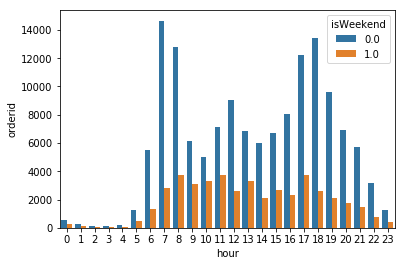

In [18]:
_timeAnalysis(train)

### 小结  
1、训练集中包含共有14天的数据。    
2、早上7点/8点及下午6点/7点骑行订单最多，符合早晚高峰出行的实际情况。  
3、周一到周日订单基本都在20万左右，周三周四最多。差距不是很大。  
4、周末订单很少，订单最多的是工作日早晚高峰时期。  

### 2、从出行距离上进行分析

In [19]:
#出行距离的描述统计
train['start_end_distance'].describe()

count    1.607048e+06
mean     7.342807e+02
std      7.269804e+02
min      6.637380e+01
25%      3.391308e+02
50%      6.108120e+02
75%      9.162180e+02
max      4.458933e+04
Name: start_end_distance, dtype: float64

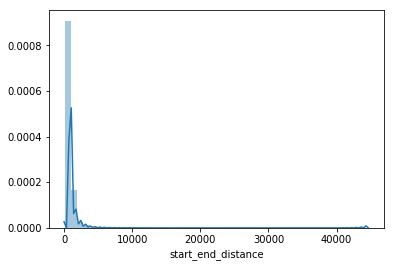

In [20]:
sns.distplot(train['start_end_distance'])

从骑行距离的统计来看，大部分人都骑行不超过1公里，较为符合短途骑行的特点。最远的有40公里，属于异常值。  
将超过5公里的去掉，查看分布情况。

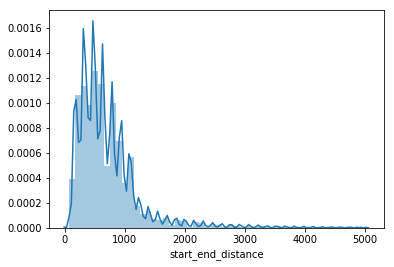

In [21]:
start_end_distance = train['start_end_distance']
start_end_distance = start_end_distance.loc[start_end_distance < 5000]
sns.distplot(start_end_distance)

绝大多数骑行距离不超过1公里。

### 小结  
绝大多数骑行距离在1公里以内，符合摩拜单车解决最后一公里的服务特点。

### 3、时间x距离进行分析

In [22]:
#不同时间骑行的距离
hour_group = train.groupby('hour')
hour_distance = hour_group.agg({'start_end_distance':'mean'}).reset_index()

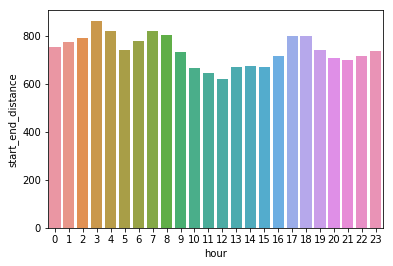

In [24]:
sns.barplot(x = 'hour', y = 'start_end_distance', data = hour_distance)

###  小结  
在不同时间上的平均骑行距离基本是一致的，没有特别突出的情况。

### 4、从小时上进行分析

In [26]:
#不同小时的出行次数
hour_num_df = hour_group.agg({'orderid':'count'}).reset_index()
hour_num_df.head()

,hour,orderid
0,0,6699
1,1,3167
2,2,1878
3,3,1415
4,4,2225


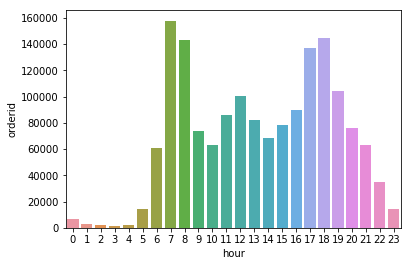

In [27]:
sns.barplot(x = 'hour', y = 'orderid', data = hour_num_df)

早晚高峰出行次数最多

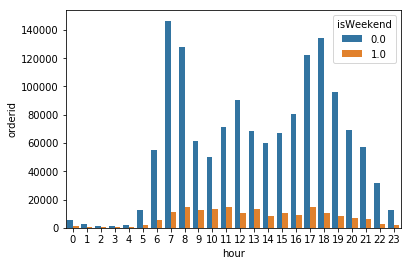

In [28]:
#工作日与非工作日不同小时的出行次数
w_hour_group = train.groupby(['isWeekend', 'hour'])
w_hour_num_df = w_hour_group.agg({'orderid':'count'}).reset_index()
sns.barplot(x = 'hour', y = 'orderid', data = w_hour_num_df, hue = 'isWeekend')

### 小结  
双休日没有早晚高峰出行特点

## 总结  
1、工作日出行次数较多，双休日出行次数较少。  
2、工作日有早晚出行高峰的特点，双休日没有。  
3、骑行距离一般不超过1公里。  
结论：出行时间与是否工作日这两个特征对用户行为有着重要的影响。